# Подключение к базе

In [2]:
# Подключение к PostgreSQL и загрузка данных
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# ── НАСТРОЙКИ ПОДКЛЮЧЕНИЯ ──
DB_USER = "postgres"
DB_PASS = "1"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

# Строка подключения
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Загружаем основную таблицу
query = """
SELECT
    has_site,
    review_count,
    rating,
    log_review_count,
    has_any_review,
    has_enough_reviews,
    name,
    adress
FROM firms_for_analysis
WHERE review_count IS NOT NULL   -- на всякий случай
"""

df = pd.read_sql(query, engine)

print("Размер данных:", df.shape)
print(df.head(5))

Размер данных: (4421, 8)
   has_site  review_count  rating  log_review_count  has_any_review  \
0     False             1     NaN          0.000000            True   
1     False            15     4.7          2.708050            True   
2      True             0     4.4               NaN           False   
3     False            19     4.8          2.944439            True   
4     False            25     4.9          3.218876            True   

   has_enough_reviews             name  \
0               False         Адвокаты   
1                True        Правоград   
2               False       Аккаунтинг   
3                True  Автострахование   
4                True          Юрист13   

                                             adress  
0                          Можайское ш., 33, Москва  
1             Симферопольский пр., 1, Москваофис 30  
2                 Окружной пр., 15, корп. 2, Москва  
3  Нагатинская ул., 2, корп. 2, МоскваПодьезды 3, 8  
4                      На

In [4]:
# 1. Размер и типы
print(df.shape)
print(df.dtypes)
print("\nПропуски:")
print(df.isnull().sum())

# 2. Группировка — это твоя основная таблица для сравнения
print("\nСравнение групп:")
print(
    df.groupby('has_site').agg({
        'review_count': ['count', 'mean', 'median', 'max'],
        'rating': ['mean', 'median'],
        'log_review_count': ['mean']
    }).round(2)
)

# 3. Процент фирм с отзывами
print("\nДоля фирм с отзывами:")
print(df['has_any_review'].value_counts(normalize=True) * 100)

print("\nДоля с 5+ отзывами:")
print(df['has_enough_reviews'].value_counts(normalize=True) * 100)

(4421, 8)
has_site                 bool
review_count            int64
rating                float64
log_review_count      float64
has_any_review           bool
has_enough_reviews       bool
name                      str
adress                    str
dtype: object

Пропуски:
has_site                 0
review_count             0
rating                 771
log_review_count      1422
has_any_review           0
has_enough_reviews       0
name                     0
adress                   0
dtype: int64

Сравнение групп:
         review_count                     rating        log_review_count
                count   mean median   max   mean median             mean
has_site                                                                
False            1267  21.33    1.0  1777   4.52    4.6             2.29
True             3154  42.63    8.0  1943   4.57    4.6             2.84

Доля фирм с отзывами:
has_any_review
True     67.835331
False    32.164669
Name: proportion, dtype: float64

Дол

# Графики

In [8]:
import os

# Создаём папку images, если её нет
os.makedirs('images', exist_ok=True)
print("Папка images создана или уже существует")

Папка images создана или уже существует


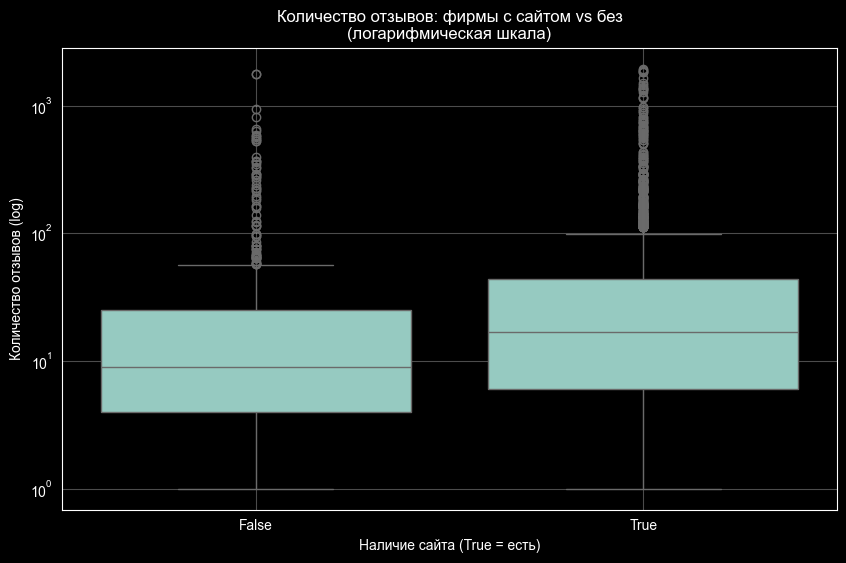

In [9]:
# График 1. Боксплот количества отзывов (лог-шкала)
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_site', y='review_count', data=df[df['review_count'] > 0])
plt.yscale('log')
plt.title('Количество отзывов: фирмы с сайтом vs без\n(логарифмическая шкала)')
plt.xlabel('Наличие сайта (True = есть)')
plt.ylabel('Количество отзывов (log)')
plt.grid(True, alpha=0.3)
plt.savefig('images/boxplot_reviews_log.png', dpi=300, bbox_inches='tight')
plt.show()

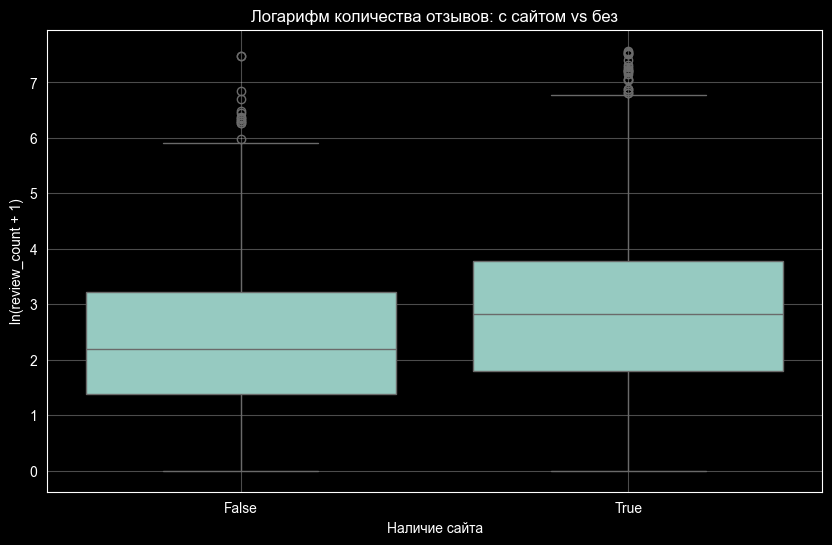

In [10]:
# График 2. Боксплот логарифма (ещё более читаемо)
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_site', y='log_review_count', data=df)
plt.title('Логарифм количества отзывов: с сайтом vs без')
plt.xlabel('Наличие сайта')
plt.ylabel('ln(review_count + 1)')  # если есть нули, можно добавить +1
plt.grid(True, alpha=0.3)
plt.savefig('images/boxplot_log_reviews.png', dpi=300, bbox_inches='tight')
plt.show()

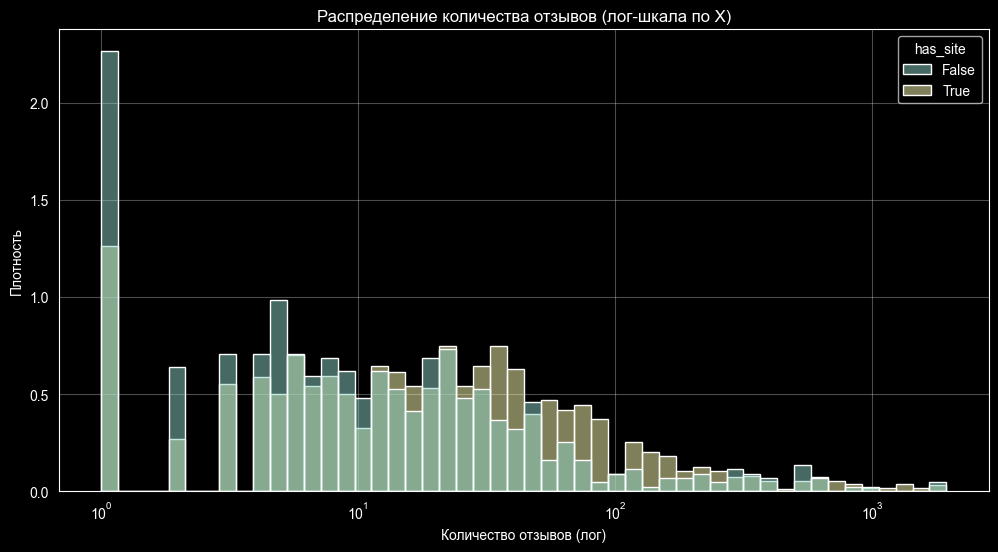

In [11]:
# График 3. Гистограмма распределения (лог-шкала по X)
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df[df['review_count'] > 0],
    x='review_count',
    hue='has_site',
    bins=50,
    log_scale=(True, False),
    stat='density',
    common_norm=False
)
plt.title('Распределение количества отзывов (лог-шкала по X)')
plt.xlabel('Количество отзывов (лог)')
plt.ylabel('Плотность')
plt.grid(True, alpha=0.3)
plt.savefig('images/hist_reviews_logx.png', dpi=300, bbox_inches='tight')
plt.show()

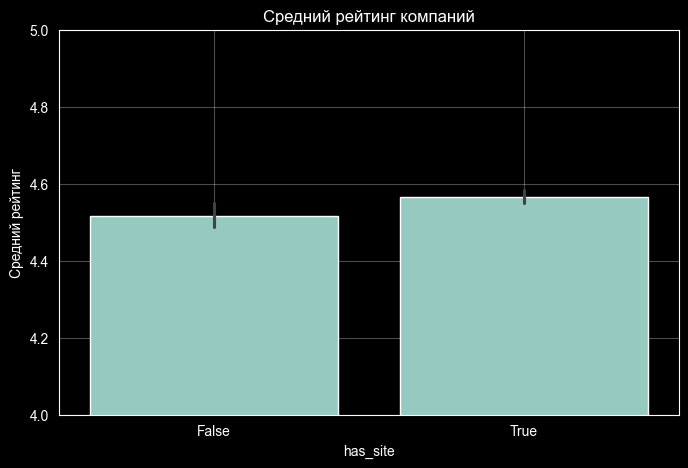

In [12]:
# График 4. Средний рейтинг
plt.figure(figsize=(8, 5))
sns.barplot(x='has_site', y='rating', data=df, errorbar='ci')
plt.title('Средний рейтинг компаний')
plt.ylabel('Средний рейтинг')
plt.ylim(4.0, 5.0)
plt.grid(True, alpha=0.3)
plt.savefig('images/bar_mean_rating.png', dpi=300, bbox_inches='tight')
plt.show()

# Статистические тесты
## Mann-Whitney U тест

In [13]:
from scipy import stats

# Две группы
with_site     = df[df['has_site'] == True]['review_count']
without_site  = df[df['has_site'] == False]['review_count']

# Тест (альтернатива: у группы с сайтом больше отзывов)
u_stat, p_val = stats.mannwhitneyu(
    with_site,
    without_site,
    alternative='greater'
)

print("Mann-Whitney U тест")
print(f"  U-статистика = {u_stat:,.0f}")
print(f"  p-value      = {p_val:.2e}")
print(f"  Вывод        = {'различия значимы' if p_val < 0.05 else 'различия НЕ значимы'} при α = 0.05")

Mann-Whitney U тест
  U-статистика = 2,598,719
  p-value      = 2.17e-57
  Вывод        = различия значимы при α = 0.05


## Дополнительные статистические тесты

### 1. Mood’s median test (равенство медиан)

In [14]:
from scipy.stats import median_test

stat, p, med, tbl = median_test(
    df[df['has_site'] == True]['review_count'],
    df[df['has_site'] == False]['review_count'],
    correction = True  # Yates' correction
)

print("Mood’s median test (равенство медиан)")
print(f"  Статистика = {stat:.2f}")
print(f"  p-value    = {p:.2e}")
print(f"  Общая медиана = {med}")

Mood’s median test (равенство медиан)
  Статистика = 197.37
  p-value    = 7.84e-45
  Общая медиана = 6.0


### 2. Kolmogorov-Smirnov (сравнение распределений)

In [15]:
from scipy.stats import ks_2samp

ks_stat, ks_p = ks_2samp(
    df[df['has_site'] == True]['review_count'],
    df[df['has_site'] == False]['review_count'],
    alternative='greater'  # можно убрать, если не нужна односторонняя альтернатива
)

print("Kolmogorov-Smirnov тест")
print(f"  KS-статистика = {ks_stat:.4f}")
print(f"  p-value       = {ks_p:.2e}")

Kolmogorov-Smirnov тест
  KS-статистика = 0.0000
  p-value       = 1.00e+00


### 3. Bootstrap доверительный интервал для разницы средних

In [16]:
import numpy as np

def bootstrap_mean_diff(data1, data2, n_boot=10000):
    diffs = []
    for _ in range(n_boot):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diffs.append(sample1.mean() - sample2.mean())
    return np.percentile(diffs, [2.5, 97.5])

with_site     = df[df['has_site'] == True]['review_count'].values
without_site  = df[df['has_site'] == False]['review_count'].values

ci_low, ci_high = bootstrap_mean_diff(with_site, without_site)

print("Bootstrap 95% доверительный интервал для разницы средних (с сайтом − без сайта)")
print(f"  [{ci_low:.1f}, {ci_high:.1f}]")
print(f"  Средняя разница ≈ {with_site.mean() - without_site.mean():.1f}")

Bootstrap 95% доверительный интервал для разницы средних (с сайтом − без сайта)
  [13.7, 28.5]
  Средняя разница ≈ 21.3


### 4. Z-тест для разницы долей (≥5 отзывов)

In [18]:
from statsmodels.stats.proportion import proportions_ztest

# Доли фирм с 5+ отзывами
count = [df[df['has_site'] == True]['has_enough_reviews'].sum(),
         df[df['has_site'] == False]['has_enough_reviews'].sum()]

nobs = [len(df[df['has_site'] == True]),
        len(df[df['has_site'] == False])]

z_stat, p_prop = proportions_ztest(count, nobs, alternative='larger')

print("Z-тест для разницы долей (≥5 отзывов)")
print(f"  z-статистика = {z_stat:.2f}")
print(f"  p-value      = {p_prop:.2e}")

Z-тест для разницы долей (≥5 отзывов)
  z-статистика = 14.14
  p-value      = 1.04e-45


### 5. Welch’s t-тест на логарифмах

In [19]:
t_stat_log, p_log = stats.ttest_ind(
    df[df['has_site'] == True]['log_review_count'].dropna(),
    df[df['has_site'] == False]['log_review_count'].dropna(),
    equal_var=False,           # Welch’s t-test
    alternative='greater'
)

print("Welch’s t-тест на логарифмах количества отзывов")
print(f"  t-статистика = {t_stat_log:.2f}")
print(f"  p-value      = {p_log:.2e}")

Welch’s t-тест на логарифмах количества отзывов
  t-статистика = 8.17
  p-value      = 4.45e-16


## Анализ нулевых фирм

### 1. Доля нулевых отзывов — основная метрика

In [20]:
# Доля нулевых отзывов по группам
zero_pct = df.groupby('has_site')['review_count'].apply(lambda x: (x == 0).mean() * 100).round(1)

print("Доля фирм с 0 отзывами:")
print(zero_pct)

Доля фирм с 0 отзывами:
has_site
False    47.5
True     26.0
Name: review_count, dtype: float64


→ Фирмы без сайта почти в 2 раза чаще вообще не имеют отзывов.
## 2. Условная вероятность: если есть сайт → вероятность иметь хотя бы 1 отзыв

In [21]:
# Вероятность иметь ≥1 отзыв | наличие сайта
p_review_given_site = df.groupby('has_site')['has_any_review'].mean() * 100

print("Вероятность иметь хотя бы 1 отзыв:")
print(p_review_given_site.round(1))

Вероятность иметь хотя бы 1 отзыв:
has_site
False    52.5
True     74.0
Name: has_any_review, dtype: float64


→ Если у фирмы есть сайт — вероятность получить хотя бы один отзыв на 21–22 п.п. выше.
## 3. График — доля нулевых отзывов

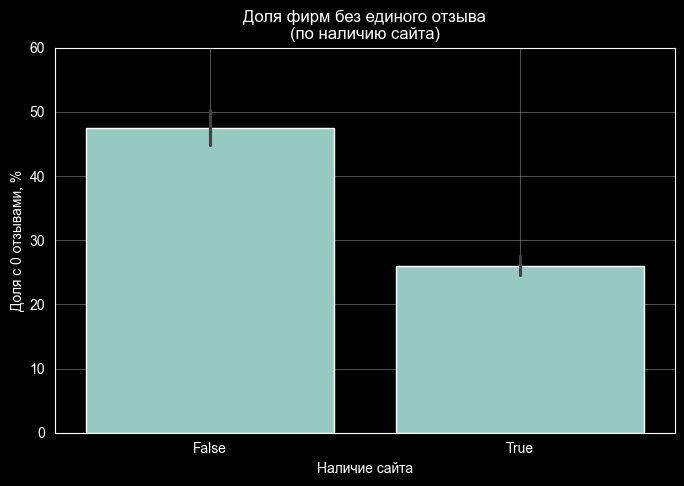

In [22]:
plt.figure(figsize=(8, 5))
sns.barplot(x='has_site', y='review_count', data=df, estimator=lambda x: (x == 0).mean() * 100)
plt.title('Доля фирм без единого отзыва\n(по наличию сайта)')
plt.ylabel('Доля с 0 отзывами, %')
plt.xlabel('Наличие сайта')
plt.ylim(0, 60)
plt.grid(True, alpha=0.3)
plt.savefig('images/bar_zero_reviews_pct.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Дополнительный тест для доли нулевых (z-тест пропорций)

In [23]:
from statsmodels.stats.proportion import proportions_ztest

# Количество нулевых в каждой группе
zero_counts = [
    (df[df['has_site'] == True]['review_count'] == 0).sum(),
    (df[df['has_site'] == False]['review_count'] == 0).sum()
]

n_groups = [len(df[df['has_site'] == True]), len(df[df['has_site'] == False])]

z_stat, p_zero = proportions_ztest(zero_counts, n_groups, alternative='smaller')  # меньшая доля у с сайтом

print("Z-тест для доли нулевых отзывов")
print(f"  z = {z_stat:.2f}")
print(f"  p-value = {p_zero:.2e}")
print(f"  Вывод: доля нулевых у фирм с сайтом значимо ниже (p < 0.001)")

Z-тест для доли нулевых отзывов
  z = -13.85
  p-value = 6.55e-44
  Вывод: доля нулевых у фирм с сайтом значимо ниже (p < 0.001)


### Отдельный взгляд на фирмы без отзывов

- Доля фирм без единого отзыва:
  - с сайтом → **26.0%**
  - без сайта → **47.5%**
  → разница **21.5 п.п.** в пользу компаний с сайтом

- Z-тест для разницы долей нулевых: **p-value < 0.001** (значимо меньше у фирм с сайтом)

**Интерпретация**: наличие сайта существенно снижает вероятность остаться без отзывов вообще.
Это один из самых понятных и сильных аргументов в пользу создания сайта.